In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm_notebook as tqdm
import random

import agent
import blockworld

from blockworld import Blockworld

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def make_letters(start, number):
    '''Returns list of `number` letters, starting from `start`. Letters are generated in ASCII sequence.'''
    return [chr(ord(start) + i) for i in range(number)]

abc = make_letters('A', 3)
print(abc)
assert abc == ['A', 'B', 'C']
_def = make_letters('D', 3)
assert _def == ['D', 'E', 'F']

['A', 'B', 'C']


In [226]:
def generate_blockworld_problem(
    B,
    heights,
    n_probs=100,
    seed=None,
):
    '''
    Generate blockworld problem.

    The problem has number of letters B and spaces S.
    To generate, we randomly select a letter (without replacement)
    and place it at a random space, ensuring that height constraints
    are satisfied.
    '''
    S = len(heights)
    problems = []
    letters = make_letters('A', B)
    spaces = range(S)

    # You have B letters and S spaces. Until all have been placed,
    # choose random letter without replacement to put at random space.
    initial = [() for _ in spaces]
    for letter in np.random.permutation(letters):
        space = np.random.choice([s for s in spaces if len(initial[s]) < heights[s]])
        initial[space] += (letter,)
    return tuple(initial), letters

heights = (3, 2, 1)
initial, letters = generate_blockworld_problem(3, heights)
print('Sample initial state', initial, letters)

def _generate_standard_goals_for_tol(initial, column_index=0, debug=True):
    letters = sorted([l for ls in initial for l in ls])
    goals = []
    for top, bottom in reversed(list(zip(letters[:-1], letters[1:]))):
        goals.append(Blockworld.make_above_predicate(top, bottom))
    goals_with_clearing = [Blockworld.make_is_bottom_of_column_predicate(letters[-1], column_index=column_index)]+goals
    if debug:
        for idx, g in enumerate(goals_with_clearing):
            print('Goal {}: {}'.format(idx, g.__name__))
    return goals_with_clearing


Sample initial state (('B',), ('A',), ('C',)) ['A', 'B', 'C']


In [227]:
B = 5

heights = (B, B-1, B-2)
generated = []
for _ in range(200):
    initial, _ = generate_blockworld_problem(B, heights)
    generated.append(initial)

print('Example initial', generated[0])
print('total', len(generated), 'unique', len(set(generated)))

generated = list(set(generated))
goals_with_clearing = _generate_standard_goals_for_tol(generated[0])

Example initial ((), ('D', 'B', 'A'), ('C', 'E'))
total 200 unique 188
Goal 0: E is at the bottom of column 0
Goal 1: D is on top of E
Goal 2: C is on top of D
Goal 3: B is on top of C
Goal 4: A is on top of B


In [106]:
allres = []
kvals = range(1, len(goals_with_clearing)+1)

for initial in tqdm(generated):
    problem = Blockworld(initial, goals_with_clearing, height_limits=heights)
    #print('\nNew problem:', initial)
    #print(problem.render(initial))
    len_optimal = len(agent.bfs_search(problem))
    #print('optimal', len_optimal)
    kres = []
    for k in kvals:
        #print('considering k={}'.format(k), end='')
        results = [
            # returns history, solved
            agent.solve_using_ordered_goal_subset_astar(problem, k=k)
            for _ in range(3)
        ]
        assert all(solved for history, solved in results), 'Did not solve for problem={initial} k={k}'
        scores = [len(h) - 1 for h, _ in results]
        kres.append(scores)
        '''
        # HACK HACK maybe for each problem, compute for each k the xxxx
        if all(solved for history, solved in results):
            msg = 'All solved'
        elif any(solved for history, solved in results):
            msg = 'Some solved'
        else:
            msg = 'Could not be solved'
        print(' {}; # moves in {} trials'.format(msg, len(results)), [len(h) - 1 for h, _ in results])
        '''
    allres.append((initial, len_optimal, kvals, kres))


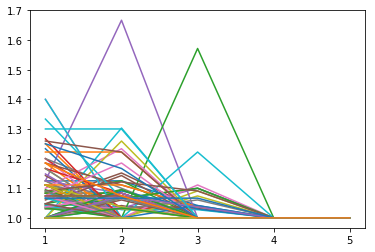

In [107]:
f, ax = plt.subplots()
ax.set_xticks(kvals)
for row in allres:
    initial, len_optimal, kvals, kres = row
    alpha = 1.0
    if kres[1] == 1.0:
        alpha = 0.3
    ax.plot(kvals, [np.mean(scores)/len_optimal for scores in kres], alpha=alpha)

In [229]:
def score_k_differentiability(row):
    initial, len_optimal, kvals, kres = row

    num_moves = [np.mean(scores) for scores in kres]

    # HACK might be better to get the actual range instead?
    # This may not work for various reasons...
    moves_range = num_moves[0]-num_moves[-1]

    #num_drops = sum(1 if num_moves[idx-1] > num_moves[idx] else 0 for idx in range(1, len(num_moves)))
    num_drops = sum(
        1 if num_moves[idx-1] > num_moves[idx] + 0.5 else 0
        for idx in range(1, len(num_moves)))
    num_increases = sum(
        1 if num_moves[idx-1] < num_moves[idx] else 0
        for idx in range(1, len(num_moves)))

    return (moves_range-2) + num_drops - num_increases
    # We want considering more goals to mean you will be more efficient
    # We also think that it's best for this efficiency to be well-distributed
    # across the different k, so upweight based on that.
    return moves_range + 5 * (num_drops-1)

allres = d['B=5,H=5,5,5']

kdiff = [score_k_differentiability(row) for row in allres]

for (initial, len_optimal, kvals, kres), kd in sorted(zip(allres, kdiff), key=lambda pair: pair[-1])[-20:]:
    print('score', initial, kd)

score ((), ('D', 'B'), ('C', 'E', 'A')) 2.0
score (('C',), ('B', 'A', 'D'), ('E',)) 2.0
score (('E',), ('C', 'A', 'D'), ('B',)) 2.0
score (('D',), ('B', 'A'), ('E', 'C')) 2.0
score (('E', 'C'), ('D', 'B', 'A'), ()) 2.1999999999999993
score ((), ('C', 'E', 'B'), ('D', 'A')) 2.4000000000000004
score (('E', 'A'), ('C', 'B'), ('D',)) 2.4000000000000004
score (('C',), ('B', 'A', 'E'), ('D',)) 2.5999999999999996
score ((), ('B', 'A', 'E', 'C'), ('D',)) 2.5999999999999996
score (('D', 'B'), ('A', 'C', 'E'), ()) 3.0
score ((), ('C', 'B', 'A', 'D', 'E'), ()) 3.0
score ((), ('B', 'A', 'D'), ('E', 'C')) 3.0
score (('E',), ('C', 'B', 'A'), ('D',)) 3.0
score ((), ('C', 'B', 'A', 'D'), ('E',)) 3.0
score (('E',), ('C', 'B', 'A', 'D'), ()) 3.0
score (('E',), ('C', 'A', 'B'), ('D',)) 3.0
score (('E',), ('C', 'A', 'B', 'D'), ()) 3.0
score (('E', 'D'), ('C', 'B', 'A'), ()) 3.1999999999999993
score ((), ('C', 'E', 'A'), ('D', 'B')) 3.5999999999999996
score (('D', 'B', 'A'), ('C', 'E'), ()) 3.8000000000000

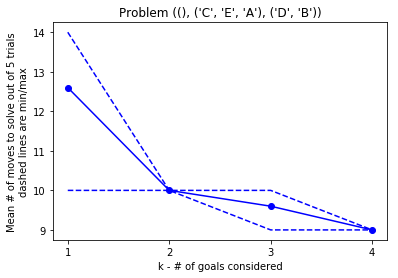

In [231]:
problem = ((), ('C', 'E', 'A'), ('D', 'B'))
initial, len_optimal, kvals, kres = next(row for row in allres if row[0] == problem)

f, ax = plt.subplots()
ax.set_title('Problem {}'.format(problem))
ax.set_xlabel('k - # of goals considered')
ax.set_ylabel(f'Mean # of moves to solve out of {len(kres[1])} trials\ndashed lines are min/max')

color = 'b'
ax.plot(kvals, [np.mean(k) for k in kres], color+'-o')
ax.plot(kvals, [np.max(k) for k in kres], color+'--')
ax.plot(kvals, [np.min(k) for k in kres], color+'--')
ax.set_xticks(kvals)

None

In [210]:
import json
#initial = (('D',), ('B', 'E', 'A', 'C'), ())
out = dict(
    initial=initial,
    goal=(tuple(sorted((l for c in initial for l in c), reverse=True)), (), ()),
    heightLimits=heights,
)

print('{')
for idx, (key, value) in enumerate(out.items()):
    end = '' if idx == len(out)-1 else ','
    print(f'  "{key}": {json.dumps(value)}{end}')
print('}')

{
  "initial": [["B", "E", "A"], ["C"], ["D"]],
  "goal": [["E", "D", "C", "B", "A"], [], []],
  "heightLimits": [5, 4, 3]
}


In [238]:
problem = Blockworld(initial, _generate_standard_goals_for_tol(initial, column_index=1), height_limits=(5, 5, 5))
history, solved = agent.solve_using_ordered_goal_subset_astar(problem, k=2, debug=True)

Goal 0: E is at the bottom of column 2
Goal 1: D is on top of E
Goal 2: C is on top of D
Goal 3: B is on top of C
Goal 4: A is on top of B
State at t=1
...
...
.A.
.EB
.CD
Current goals: ['E is at the bottom of column 2', 'D is on top of E']
Planned to get to (('B', 'A'), ('C',), ('E', 'D')) via actions [('B', 0), ('A', 0), ('D', 0), ('E', 2), ('D', 2)]

State at t=2
...
...
.A.
.E.
BCD

State at t=3
...
...
...
AE.
BCD

State at t=4
...
...
D..
AE.
BC.

State at t=5
...
...
D..
A..
BCE
* Halted execution of action plan because we satisfied goal "E is at the bottom of column 2".
State at t=5
...
...
D..
A..
BCE
Current goals: ['D is on top of E', 'C is on top of D']
Planned to get to (('B', 'A'), (), ('E', 'D', 'C')) via actions [('D', 2), ('C', 2)]

State at t=6
...
...
...
A.D
BCE
* Halted execution of action plan because we satisfied goal "D is on top of E".
State at t=6
...
...
...
A.D
BCE
Current goals: ['C is on top of D', 'B is on top of C']
Planned to get to ((), ('A',), ('E', 

In [140]:
# This was a way of seeing why some problems seemed to have super-optimal solutions with A*.
# the issue was generated subproblems didn't have height limits
for initial, len_optimal, kvals, kres in allres:
    if len_optimal != kres[-1][0]:
        print('XXX why is this different? problem', initial, len_optimal, kvals, kres)

In [299]:
# We want to know if height limits change things by much.
# So, we're asking if varying height limits, from (5, 5, 5) to (5, 4, 3) to (5, 3, 2)
# - changes k-differentiability
# - changes average difficulty for k=2 or k=3

def _test_out_problem_type(B, heights):
    num = 1000
    generated = list(set(generate_blockworld_problem(B, heights)[0] for _ in range(num)))
    print(f'Generated {len(generated)} unique problems out of {num}')
    column_index = 0
    if all(h==heights[0] for h in heights):
        column_index = 1
    goals_with_clearing = _generate_standard_goals_for_tol(generated[0], column_index=column_index)

    # HACK keeping it simple
    kvals = [1, 2, 3, 4]

    allres = []

    for initial in tqdm(generated):
        problem = Blockworld(initial, goals_with_clearing, height_limits=heights)
        len_optimal = len(agent.bfs_search(problem))
        kres = []
        for k in kvals:
            results = [
                # returns history, solved
                agent.solve_using_ordered_goal_subset_astar(problem, k=k)
                for _ in range(5)
            ]
            assert all(solved for history, solved in results), f'Did not solve for problem={initial} k={k}'
            scores = [len(h) - 1 for h, _ in results]
            kres.append(scores)
        allres.append((initial, len_optimal, kvals, kres))
    return allres


#d = {}
d['B=6,H=6,6,6'] = _test_out_problem_type(6, (6, 6, 6))
d['B=6,H=6,5,4'] = _test_out_problem_type(6, (6, 5, 4))

d['B=5,H=5,5,5'] = _test_out_problem_type(5, (5, 5, 5))
d['B=5,H=5,4,3'] = _test_out_problem_type(5, (5, 4, 3))
d['B=5,H=5,3,3'] = _test_out_problem_type(5, (5, 3, 3))
d['B=5,H=5,3,2'] = _test_out_problem_type(5, (5, 3, 2))

d['B=4,H=4,4,4'] = _test_out_problem_type(4, (4, 4, 4))
d['B=4,H=4,3,2'] = _test_out_problem_type(4, (4, 3, 2))
d['B=3,H=3,3,3'] = _test_out_problem_type(3, (3, 3, 3))
d['B=3,H=3,2,1'] = _test_out_problem_type(3, (3, 2, 1))

Generated 955 unique problems out of 1000
Goal 0: F is at the bottom of column 1
Goal 1: E is on top of F
Goal 2: D is on top of E
Goal 3: C is on top of D
Goal 4: B is on top of C
Goal 5: A is on top of B


Generated 959 unique problems out of 1000
Goal 0: F is at the bottom of column 0
Goal 1: E is on top of F
Goal 2: D is on top of E
Goal 3: C is on top of D
Goal 4: B is on top of C
Goal 5: A is on top of B


Generated 754 unique problems out of 1000
Goal 0: E is at the bottom of column 1
Goal 1: D is on top of E
Goal 2: C is on top of D
Goal 3: B is on top of C
Goal 4: A is on top of B


Generated 719 unique problems out of 1000
Goal 0: E is at the bottom of column 0
Goal 1: D is on top of E
Goal 2: C is on top of D
Goal 3: B is on top of C
Goal 4: A is on top of B


Generated 724 unique problems out of 1000
Goal 0: E is at the bottom of column 0
Goal 1: D is on top of E
Goal 2: C is on top of D
Goal 3: B is on top of C
Goal 4: A is on top of B


Generated 625 unique problems out of 1000
Goal 0: E is at the bottom of column 0
Goal 1: D is on top of E
Goal 2: C is on top of D
Goal 3: B is on top of C
Goal 4: A is on top of B


Generated 292 unique problems out of 1000
Goal 0: D is at the bottom of column 1
Goal 1: C is on top of D
Goal 2: B is on top of C
Goal 3: A is on top of B


Generated 234 unique problems out of 1000
Goal 0: D is at the bottom of column 0
Goal 1: C is on top of D
Goal 2: B is on top of C
Goal 3: A is on top of B


Generated 60 unique problems out of 1000
Goal 0: C is at the bottom of column 1
Goal 1: B is on top of C
Goal 2: A is on top of B


Generated 36 unique problems out of 1000
Goal 0: C is at the bottom of column 0
Goal 1: B is on top of C
Goal 2: A is on top of B


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


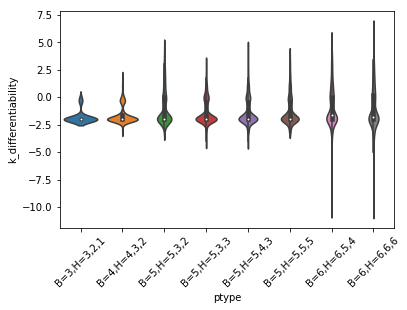

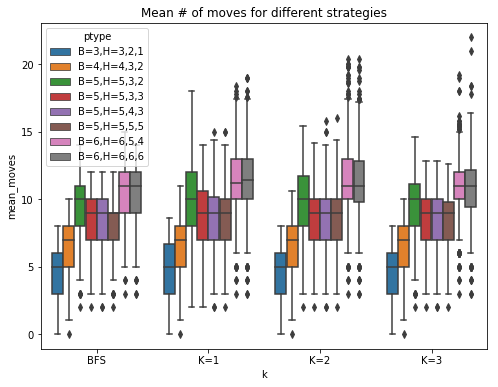

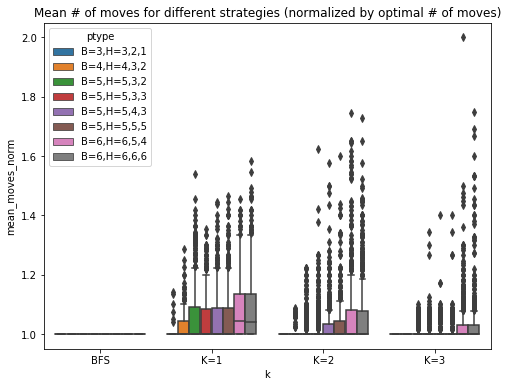

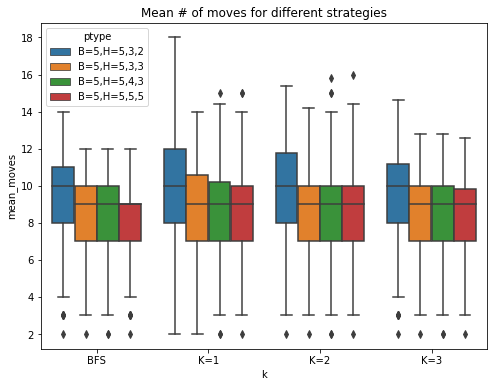

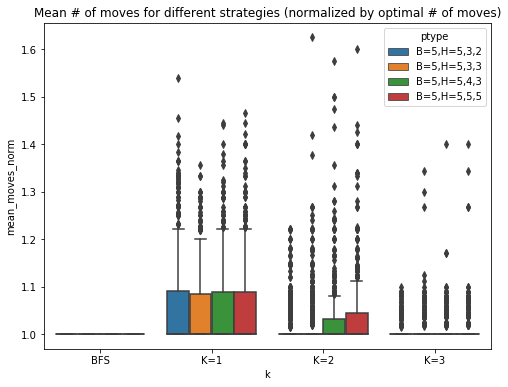

In [298]:
import seaborn as sns
import pandas as pd

rows = []
for ptype, vals in sorted(d.items()):
    for row in vals:
        initial, len_optimal, kvals, kres = row
        rows.append(dict(
            ptype=ptype,
            k_differentiability=score_k_differentiability(row),
            len_optimal=len_optimal,
            mean_k1=np.mean(kres[kvals.index(1)]),
            mean_k2=np.mean(kres[kvals.index(2)]),
            mean_k3=np.mean(kres[kvals.index(3)]),
        ))

df = pd.DataFrame(rows)
for col in ['len_optimal', 'mean_k1', 'mean_k2', 'mean_k3']:
    # So this normalized column is relative to optimal, so larger values means less optimal.
    df[col+'_norm'] = df[col] / df['len_optimal']

#plt.figure()
#sns.violinplot(x='ptype', y='len_optimal', data=df)

plt.figure()
# HACK or boxplot instead?
sns.violinplot(x='ptype', y='k_differentiability', data=df)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

for filtered_df in [df, df.loc[df.ptype.str.startswith('B=5')]]:
    '''
    f = plt.figure()
    plt.title('Count of k-differentiability values\nk-differentiability is the count of values k which have\nlower # of moves than k-1 for a given problem\n')
    #sns.violinplot(x='ptype', y='k_differentiability', data=df)
    sns.distplot('k_differentiability', hue='ptype', data=filtered_df)
    f.get_axes()[0].set_yscale('log')
    plt.ylabel('Number of problems')
    '''

    names = ['BFS', 'K=1', 'K=2', 'K=3']

    plt.figure(figsize=(8, 6))
    plt.title('Mean # of moves for different strategies')
    kcols = ['len_optimal', 'mean_k1', 'mean_k2', 'mean_k3']
    reshaped_df = filtered_df[['ptype']+kcols].melt(id_vars=['ptype'], var_name='k', value_name='mean_moves')
    reshaped_df['k'] = reshaped_df['k'].apply(lambda col: names[kcols.index(col)])
    sns.boxplot(x='k', y='mean_moves', hue='ptype', data=reshaped_df)

    plt.figure(figsize=(8, 6))
    plt.title('Mean # of moves for different strategies (normalized by optimal # of moves)')
    kcols = ['len_optimal_norm', 'mean_k1_norm', 'mean_k2_norm', 'mean_k3_norm']
    reshaped_df = filtered_df[['ptype']+kcols].melt(id_vars=['ptype'], var_name='k', value_name='mean_moves_norm')
    reshaped_df['k'] = reshaped_df['k'].apply(lambda col: names[kcols.index(col)])
    sns.boxplot(x='k', y='mean_moves_norm', hue='ptype', data=reshaped_df)

In [246]:
keys = ['B=5,H=5,5,5', 'B=5,H=5,4,3', 'B=5,H=5,3,3', 'B=5,H=5,3,2']

indexed = {
    key: xx
    for key in keys
}


h555 = {
    # HACK have to do this trick to rearrange things so we share a goal
    (row[0][1], row[0][0], row[0][2]): row
    for row in d['B=5,H=5,5,5']
}
h543 = {
    row[0]: row
    for row in d['B=5,H=5,4,3']
}
h533 = {
    row[0]: row
    for row in d['B=5,H=5,3,3']
}

print(f'h555 {len(h555)} h543 {len(h543)} h333 {len(h533)}')
shared = set(h555.keys()) & set(h543.keys()) & set(h533.keys())
print(f'h555 & h543 & h533 {len(shared)}')

h555 745 h543 742 h333 717
h555 & h543 & h533 169


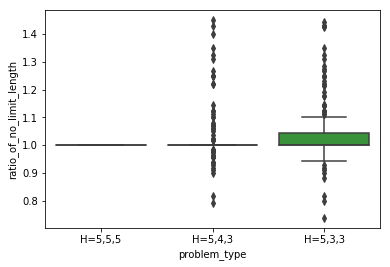

In [271]:
matchedp = []

def _len_for_row(row):
    _, len_optimal, kvals, kres = row
    # testing out k
    return np.mean(kres[kvals.index(2)])

for initial in list(shared):
    no_limit_length = _len_for_row(h555[initial])
    for problem_type, row in [
        ('H=5,5,5', h555[initial]),
        ('H=5,4,3', h543[initial]),
        ('H=5,3,3', h533[initial]),
    ]:
        length = _len_for_row(row)
        matchedp.append(dict(
            problem_type=problem_type,
            ratio_of_no_limit_length=length/float(no_limit_length),
        ))
        if length < no_limit_length:
            pass
            #print(initial, no_limit_length)
            #print(problem_type, length)
            #break

sns.boxplot('problem_type', 'ratio_of_no_limit_length', data=pd.DataFrame(matchedp))

In [280]:
B = 5

reversed_letters = tuple(make_letters('A', B)[::-1])

goal_middle = ((), reversed_letters, ())
goal_left = (reversed_letters, (), ())

info = [
    ('B=5,H=5,5,5', (5, 5, 5), goal_middle),
# Decided not to use height limits
#    ('B=5,H=5,4,3', (5, 4, 3), goal_left),
#    ('B=5,H=5,3,3', (5, 3, 3), goal_left),
]

limit = 15
result = []

for problem_type, heights, goal in info:
    top = sorted(d[problem_type], key=lambda row: score_k_differentiability(row))[-limit:]
    print(problem_type)
    for row in top:
        initial, *_ = row
        print(initial, score_k_differentiability(row))
        result.append(dict(
            initial=initial,
            goal=goal,
            #heightLimits=heights,
        ))

random.seed(42)
random.shuffle(result)
with open('trials.json', 'w') as f:
    json.dump(result, f)

B=5,H=5,5,5
((), ('C', 'E', 'B'), ('D', 'A')) 2.4000000000000004
(('E', 'A'), ('C', 'B'), ('D',)) 2.4000000000000004
(('C',), ('B', 'A', 'E'), ('D',)) 2.5999999999999996
((), ('B', 'A', 'E', 'C'), ('D',)) 2.5999999999999996
(('D', 'B'), ('A', 'C', 'E'), ()) 3.0
((), ('C', 'B', 'A', 'D', 'E'), ()) 3.0
((), ('B', 'A', 'D'), ('E', 'C')) 3.0
(('E',), ('C', 'B', 'A'), ('D',)) 3.0
((), ('C', 'B', 'A', 'D'), ('E',)) 3.0
(('E',), ('C', 'B', 'A', 'D'), ()) 3.0
(('E',), ('C', 'A', 'B'), ('D',)) 3.0
(('E',), ('C', 'A', 'B', 'D'), ()) 3.0
(('E', 'D'), ('C', 'B', 'A'), ()) 3.1999999999999993
((), ('C', 'E', 'A'), ('D', 'B')) 3.5999999999999996
(('D', 'B', 'A'), ('C', 'E'), ()) 3.8000000000000007


In [289]:
# HACK this problem breaks down often... by undoing previously accomplished goals
# HACK we've fixed the issue by accounting for our previously accomplished goals!

initial = ((), ('D', 'A', 'C'), ('B', 'E'))
problem = Blockworld(initial, _generate_standard_goals_for_tol(initial, debug=False), height_limits=(5, 3, 2))

for _ in range(5):
    history, solved = agent.solve_using_ordered_goal_subset_astar(problem, k=1, debug=False)
    print(len(history)-1, solved)

history, solved = agent.solve_using_ordered_goal_subset_astar(problem, k=1, debug=True)

10 True
10 True
10 True
10 True
10 True
State at t=1
.  
.  
.C 
.AE
.DB
Goals to solve: ['E is at the bottom of column 0']
Planned to get to (('E',), ('D', 'A', 'C'), ('B',)) via actions [('E', 0)]

State at t=2
.  
.  
.C 
.A.
EDB
* Halted execution of action plan because we satisfied goal "E is at the bottom of column 0".
State at t=2
.  
.  
.C 
.A.
EDB
Goals to solve: ['D is on top of E']
Planned to get to (('E', 'D'), ('A', 'C'), ('B',)) via actions [('C', 0), ('A', 0), ('D', 2), ('A', 1), ('C', 1), ('D', 0)]

State at t=3
.  
.  
.. 
CA.
EDB

State at t=4
.  
.  
A. 
C..
EDB

State at t=5
.  
.  
A. 
C.D
E.B

State at t=6
.  
.  
.. 
C.D
EAB

State at t=7
.  
.  
.. 
.CD
EAB

State at t=8
.  
.  
.. 
DC.
EAB
* Halted execution of action plan because we satisfied goal "D is on top of E".
State at t=8
.  
.  
.. 
DC.
EAB
Goals to solve: ['C is on top of D']
Planned to get to (('E', 'D', 'C'), ('A',), ('B',)) via actions [('C', 0)]

State at t=9
.  
.  
C. 
D..
EAB
* Halted executi

### old things

In [11]:
# Let's generate/solve a bunch of problems.

# This dict is indexed by (initial state, k) and stores a
# list of # of moves it took to solve the problem (list b/c of stochasticity)
# problem_record = {} # HACK we normally make sure this is commented out.

all_probs = []

for args in [
    dict(B=6, S=3, seed=43),

    dict(B=7, S=3, seed=43),

    dict(B=8, S=3, seed=43),

    #dict(B=9, S=3, seed=43),
    #dict(B=9, S=4, seed=43),
    #dict(B=9, S=5, seed=43),
]:
    print(f'Testing things out for args {args}')

    generated, letters = generate_blockworld_problems(n_probs=30, **args)
    goals = []
    for top, bottom in reversed(list(zip(letters[:-1], letters[1:]))):
        print('Goal {}: {} on top of {}'.format(len(goals), top, bottom))
        goals.append(Blockworld.make_above_predicate(top, bottom))
    goals_with_clearing = [Blockworld.make_is_bottom_of_column_predicate(letters[-1])]+goals

    for p in generated:
        all_probs.append((p, goals_with_clearing))

    print('Sample initial state', generated[0])

random.shuffle(all_probs)

debug = False
for initial, goals_with_clearing in tqdm(all_probs):
    problem = Blockworld(initial, goals_with_clearing)
    if debug:
        print(problem.render(initial))
        #print('optimal', len(agent.bfs_search(problem)))
    for k in range(1, len(problem.goals)+1):
        if (initial, k) in problem_record:
            # We already solved this! skip it
            continue
        if debug:
            print('considering k={}'.format(k), end='')
        results = [
            # returns history, solved
            agent.solve_using_ordered_goal_subset_astar(problem, k=k)
            for _ in range(3)
        ]
        if debug:
            if all(solved for history, solved in results):
                msg = 'All solved'
            elif any(solved for history, solved in results):
                msg = 'Some solved'
            else:
                msg = 'Could not be solved'
            print(' {}; # moves in {} trials'.format(msg, len(results)), [len(h) - 1 for h, _ in results])
        problem_record[initial, k] = [len(h) - 1 for h, _ in results]

print(len(problem_record))

Testing things out for args {'B': 6, 'S': 3, 'seed': 43}
Goal 0: E on top of F
Goal 1: D on top of E
Goal 2: C on top of D
Goal 3: B on top of C
Goal 4: A on top of B
Sample initial state (('C',), ('B',), ('F', 'D', 'A', 'E'))
Testing things out for args {'B': 7, 'S': 3, 'seed': 43}
Goal 0: F on top of G
Goal 1: E on top of F
Goal 2: D on top of E
Goal 3: C on top of D
Goal 4: B on top of C
Goal 5: A on top of B
Sample initial state (('B',), ('D', 'E'), ('F', 'C', 'G', 'A'))
Testing things out for args {'B': 8, 'S': 3, 'seed': 43}
Goal 0: G on top of H
Goal 1: F on top of G
Goal 2: E on top of F
Goal 3: D on top of E
Goal 4: C on top of D
Goal 5: B on top of C
Goal 6: A on top of B
Sample initial state (('G',), ('B', 'A'), ('D', 'H', 'F', 'C', 'E'))


630


In [24]:
problems = list(problem_record_nested.keys())
problem_scores = [score_k_differentiability(problem_record_nested[p]) for p in problems]

for pidx in sorted(range(len(problems)), key=lambda pidx: problem_scores[pidx], reverse=True)[:30]:
    p = problems[pidx]
    print(problem_scores[pidx], p)


24.0 (('G', 'F', 'D'), ('E', 'H', 'B', 'A', 'C'), ())
18.0 (('A', 'H', 'G', 'E'), ('C', 'F'), ('D', 'B'))
17.0 (('D',), ('E', 'G', 'B', 'C', 'A', 'F'), ())
15.333333333333332 (('C',), ('F', 'E', 'H', 'A', 'D'), ('B', 'G'))
15.0 (('G', 'B', 'F', 'C'), ('A',), ('E', 'H', 'D'))
15.0 (('F', 'B'), ('G',), ('H', 'D', 'E', 'C', 'A'))
13.0 (('C',), ('E', 'B', 'A'), ('D', 'G', 'F'))
13.0 (('G', 'A', 'C'), ('B', 'D', 'F'), ('E',))
13.0 (('B', 'D', 'F'), ('H', 'G', 'A', 'C'), ('E',))
13.0 (('B', 'E'), ('F', 'C'), ('G', 'D', 'A'))
12.333333333333332 (('E', 'B'), ('H', 'A', 'C'), ('F', 'G', 'D'))
12.0 (('E', 'F'), ('D', 'B', 'A'), ('C',))
11.333333333333334 (('D',), ('F', 'E', 'G', 'H', 'B', 'A'), ('C',))
11.0 (('F', 'C'), ('E', 'G', 'B', 'A'), ('H', 'D'))
11.0 (('F', 'A', 'D'), ('E', 'B', 'H'), ('G', 'C'))
11.0 (('G', 'D', 'F', 'H', 'C', 'E'), (), ('A', 'B'))
10.333333333333334 (('C', 'H'), ('D', 'E', 'A', 'G'), ('B', 'F'))
10.0 (('C', 'F', 'E', 'D'), ('A', 'G'), ('B',))
9.666666666666668 (('G',),

In [101]:
# Trying to figure out if state canonicalization helps our perf as branching factor gets large

# initial = (('B',), ('D', 'E'), ('F', 'C', 'G', 'A'))
key, value = list(problem_record.items())[110]

print(key, value)

initial, k = key

letters = sorted([l for ls in initial for l in ls])
goals = []
for top, bottom in reversed(list(zip(letters[:-1], letters[1:]))):
    print('Goal {}: {} on top of {}'.format(len(goals), top, bottom))
    goals.append(Blockworld.make_above_predicate(top, bottom))
goals_with_clearing = [Blockworld.make_is_bottom_of_column_predicate(letters[-1])]+goals

problem = Blockworld(initial, goals_with_clearing)
for _ in range(5):
    history, solved = solve_using_ordered_goal_subset(problem, k=k)
    print(len(history)-1)

def _try_to_solve_this_thing(problem, k):
    results = [
        # returns history, solved
        solve_using_ordered_goal_subset(problem, k=k)
        for _ in range(3)
    ]


#problem = Blockworld(initial, goals_with_clearing)

#%timeit _try_to_solve_this_thing(Blockworld(initial, goals_with_clearing), 6)
#%timeit _try_to_solve_this_thing(Blockworld(initial, goals_with_clearing, canonicalize_states=True), 6)
#%timeit _try_to_solve_this_thing(Blockworld(initial, goals_with_clearing), 7)
#%timeit _try_to_solve_this_thing(Blockworld(initial, goals_with_clearing, canonicalize_states=True), 7)

((('F', 'B', 'C'), ('E', 'D'), ('A',)), 5) [9, 9, 9]
Goal 0: E on top of F
Goal 1: D on top of E
Goal 2: C on top of D
Goal 3: B on top of C
Goal 4: A on top of B
9
9
9
9
9


In [ ]:
# Export to JSON!

import json

output_format = [
    dict(
        initial=initial,
        goal_type='any_column',
        goal=[
            sorted([l for ls in initial for l in ls], reverse=True),
        ] + [[]] * (len(initial)-1)
    )
    for initial in initial_states
]

print(json.dumps(output_format, indent=4))

In [ ]:
# HACK HACK why doesn't bfs terminate on this? Does it terminate with state canonicalization? Count distinct states?

'''
....
....
....
....
....
....
H..B
E.AF
CGDI
'''

### Exploring some suboptimalities

In [ ]:
# Why does this fail for even k=4? # moves in 5 trials [29, 29, 29, 29, 29]
badstate1 = (('E', 'A', 'D'), ('C', 'F'), ('B',))
# or this one fails up to k=3
badstate2 = ((), ('A', 'C', 'F'), ('E', 'D', 'B'))

# In general, this class of issue seems to have to do with not clearing underneath the largest block...
# So, if you're considering k "on top of" goals, then you'll optimize with respect to up to k letters
# away from your current one. Otherwise, you might leave k+1 letters and further underneath. So in general
# 'A' will get stuck underneath an F if we don't explicitly clear F.

print('goals without clearing:')
p = Blockworld(badstate1, goals)
history, solved = solve_using_ordered_goal_subset(p, k=3)
assert not solved
print('not solved')

# So when we add clearing as a goal, this all gets nicely resolved:
print('goals with clearing:')
p = Blockworld(badstate1, goals_with_clearing)
history, solved = solve_using_ordered_goal_subset(p, k=3)
assert solved
print('solved in {} moves'.format(len(history)-1))

In [ ]:
state = (('B', 'A', 'E', 'F'), (), ('C', 'D'))
# How is this optimal with k=1?
# After seeing the below with debug=True, it seems this is optimal because there aren't opportunities to
# achieve bad intermediate states. So for instance, once E is on F on column 2, D and C
# are already in the right order to stack. while we do have to shift A around to get B
# on top, we can't block future moves by doing that. So, this is a case where we can't
# create bad intermediate states.

p = Blockworld(state, goals_with_clearing)

print('optimal', bfs_search(p))

history, solved = solve_using_ordered_goal_subset(p, k=1, debug=False)
print('using k=1', [a for a, s in history if a])

In [133]:
# Why does this sometimes do poorly for k=1?: # moves [29, 7, 7, 7, 29]
state = (('B', 'A', 'E', 'F'), (), ('C', 'D'))

# Answer: This does poorly because we sometimes stack F on top of D, which is a weird thing to do and
# sort of related to the previous cell's long answer. When we add the "clearing" goal (that F is on bottom)
# this is a non-issue.

p = Blockworld(state, goals)

print('optimal', bfs_search(p))

for _ in range(10):
    history, solved = solve_using_ordered_goal_subset(p, k=1, debug=False)
    if not solved:
        print('rendering suboptimal solution')
        for a, s in history:
            print(p.render(s))
        break


optimal []


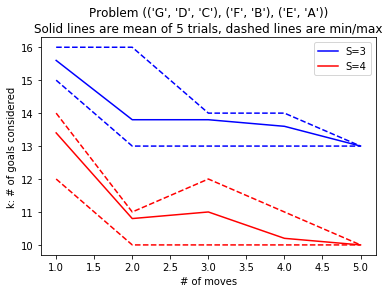

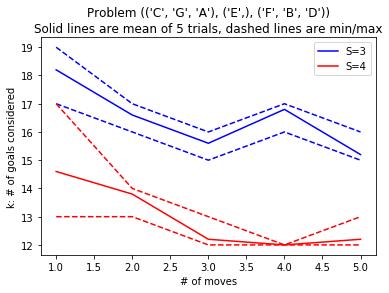

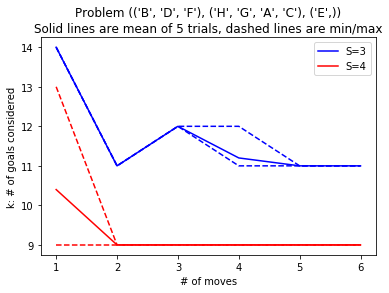

In [153]:
# How important is # spaces for solving our problems?

ps = [
    # tougher ones
    (('G', 'D', 'C'), ('F', 'B'), ('E', 'A')),
    (('C', 'G', 'A'), ('E',), ('F', 'B', 'D')),
    # "easy" ones
    (('B', 'D', 'F'), ('H', 'G', 'A', 'C'), ('E',)),
]

for initial in ps:
    n_trials = 5
    plt.figure()
    letters = _generate_standard_goals_for_blocks(initial, debug=False)
    assert len(initial) == 3
    plt.title('Problem {}\nSolid lines are mean of {} trials, dashed lines are min/max'.format(initial, n_trials))
    plt.xlabel('# of moves')
    plt.ylabel('k: # of goals considered')
    for name, arg, color in [
        ('S=3', initial, 'b'),
        ('S=4', initial+((),), 'r'),
    ]:
        p = Blockworld(arg, letters)
        # HACK Although we normally like to do up to k=# goals, we are only going up to k=# goals - 2 to keep things fast.
        ks = list(range(1, len(p.goals)-1))
        results = [
            [
                len(solve_using_ordered_goal_subset_perf1(p, k=k, debug=False)[0])-1
                for _ in range(n_trials)
            ]
            for k in tqdm(ks)
        ]
        plt.plot(ks, [np.mean(r) for r in results], color, label=name)
        plt.plot(ks, [np.max(r) for r in results], color+'--')
        plt.plot(ks, [np.min(r) for r in results], color+'--')
        plt.legend()
